# Gocase Academy- Desafio 2 Gente e Gestão

## Case 2: Otimização da análise do registro de ponto.
Na GoCase, realizamos avaliações de desempenho que envolvem várias etapas, como a 
autoavaliação do colaborador, a avaliação do líder e, por fim, a construção de um PDI 
(Plano  de  Desenvolvimento  Individual)  para  o  colaborador  avaliado.  No  entanto,  o 
processo de criação do PDI é demorado, pois exige a análise de uma grande quantidade 
de dados de diferentes colaboradores. Isso dificulta a geração de valor de forma ágil e 
eficiente.

## Desafio
Visando otimizar o processo de avaliação, crie um agente de IA que atue como um 
facilitador  na  elaboração  de  Planos  de  Desenvolvimento  Individual  (PDI).  A  IA  receberia 
dados  essenciais  para  a  análise  de  desempenho,  como  o  feedback  do  gestor,  a 
autoavaliação do colaborador e a ata de avaliação de desempenho. Com base nessas 
informações, ela sugeriria ações e planos de desenvolvimento personalizados. 
   Assim, utilizando os dados exportados da próxima página, faça a automatização da 
análise  dos  pontos  fortes  e  áreas  de  melhoria  de  cada  colaborador,  gerando 
automaticamente sugestões de planos de ação. 




In [ ]:
!pip install langgraph langchain-openai langchain-core python-dotenv typing_extensions openai fpdf openpyxl==3.1.2

In [30]:
from langgraph.graph import StateGraph, END
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage
import pandas as pd
import os
from dotenv import load_dotenv
from typing import TypedDict, Annotated, List, Union
import logging
import sys
from fpdf import FPDF  

logging.basicConfig(level=logging.INFO, stream=sys.stdout)
logger = logging.getLogger(__name__)

class AgentState(TypedDict):
    dados_brutos: pd.ExcelFile
    dados_processados: pd.DataFrame
    pdi_final: pd.DataFrame
    notas: pd.DataFrame
    gestor: pd.DataFrame
    colaborador: pd.DataFrame
    input: str

load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv('OPENAI_API_KEY')

llm = ChatOpenAI(model_name="gpt-4-turbo", temperature=0)

def debug_dataframe(df: pd.DataFrame, name: str):
    """Função auxiliar para debug de DataFrames"""
    logger.info(f"\nDebug {name}:")
    logger.info(f"Shape: {df.shape}")
    logger.info(f"Colunas: {df.columns.tolist()}")
    logger.info(f"Primeiras linhas:\n{df.head(2)}")
    logger.info("-" * 50)

def carregar_dados(state: AgentState):
    """Carrega os dados do arquivo Excel com validação"""
    try:
        logger.info(f"Iniciando carregamento de dados...")
        
        xls = pd.ExcelFile(state['input'])
        logger.info(f"Planilhas encontradas: {xls.sheet_names}")
        
        notas_df = pd.read_excel(xls, sheet_name="Notas")
        
        avaliacao_gestor_df = pd.read_excel(xls, sheet_name="Gestor")
        if 'Unnamed: 1' in avaliacao_gestor_df.columns:
            avaliacao_gestor_df = avaliacao_gestor_df.rename(columns={'Unnamed: 1': 'Feedback do Gestor'})
        
        autoavaliacao_df = pd.read_excel(xls, sheet_name="Colaborador")
        if 'Unnamed: 1' in autoavaliacao_df.columns:
            autoavaliacao_df = autoavaliacao_df.rename(columns={'Unnamed: 1': 'Autoavaliação Texto'})
        
        debug_dataframe(notas_df, "Notas")
        debug_dataframe(avaliacao_gestor_df, "Gestor")
        debug_dataframe(autoavaliacao_df, "Colaborador")
        
        return {
            "dados_brutos": xls,
            "notas": notas_df,
            "gestor": avaliacao_gestor_df,
            "colaborador": autoavaliacao_df
        }
        
    except Exception as e:
        logger.error(f"Erro no carregamento: {str(e)}")
        raise

def analisar_desempenho(state: AgentState):
    """Processa os dados com verificações de consistência"""
    try:
        logger.info("Iniciando análise de desempenho...")
        
        df = state['notas'].copy()
        
        cols_necessarias = ['Criterios', 'Pontuação final']
        if not all(col in df.columns for col in cols_necessarias):
            raise ValueError("Colunas ausentes na planilha de Notas")
        
        gestor_df = state['gestor'].copy()
        if 'Avaliação do Gestor' in gestor_df.columns:
            criterios_gestor = gestor_df['Avaliação do Gestor'].tolist()
            feedback_gestor = gestor_df['Feedback do Gestor'].tolist()
            
            feedback_dict = dict(zip(criterios_gestor, feedback_gestor))
            
            df['Feedback do Gestor'] = df['Criterios'].map(feedback_dict)
        
        colab_df = state['colaborador'].copy()
        if 'Autoavaliação' in colab_df.columns:
            criterios_colab = colab_df['Autoavaliação'].tolist()
            texto_colab = colab_df['Autoavaliação Texto'].tolist()
            
            autoav_dict = dict(zip(criterios_colab, texto_colab))
            
            df['Autoavaliação Texto'] = df['Criterios'].map(autoav_dict)
        
        df["Ponto Forte"] = df["Pontuação final"] >= 3.5
        df["Área de Melhoria"] = df["Pontuação final"] < 3
        
        debug_dataframe(df, "Dados Analisados")
        
        return {"dados_processados": df}
        
    except Exception as e:
        logger.error(f"Erro na análise: {str(e)}")
        raise

def gerar_pdi(state: AgentState):
    """Gera PDI com tratamento de erros"""
    try:
        logger.info("Iniciando geração de PDI...")
        
        df = state['dados_processados'].copy()
        resultados = []
        
        for idx, row in df.iterrows():
            logger.info(f"Processando critério {idx+1}/{len(df)}...")
            
            # Adaptar para usar os novos nomes de colunas
            autoav_texto = row.get('Autoavaliação Texto', 'Não disponível')
            feedback_gestor = row.get('Feedback do Gestor', 'Não disponível')
            
            prompt = f"""
            ## Contexto:
            Você é um especialista em RH da GoCase. Analise os seguintes dados e sugira um plano de desenvolvimento:

            **Critério**: {row['Criterios']}
            **Pontuação**: {row['Pontuação final']}
            **Feedback Gestor**: {feedback_gestor}
            **Autoavaliação**: {autoav_texto}

            ## Instruções:
            1. Identifique 1 ponto forte
            2. Aponte 1 área de melhoria
            3. Sugira 2 ações concretas
            4. Recomende 1 indicador de evolução
            """
            
            try:
                response = llm.invoke([HumanMessage(content=prompt)])
                resultados.append(response.content)
                logger.debug(f"Resposta LLM: {response.content[:100]}...")  # Log parcial
                
            except Exception as e:
                logger.warning(f"Erro na geração para critério {row['Criterios']}: {str(e)}")
                resultados.append("Erro na geração")
        
        df["PDI Sugerido"] = resultados
        debug_dataframe(df, "Resultado Final")
        
        return {"pdi_final": df}
        
    except Exception as e:
        logger.error(f"Erro geral no PDI: {str(e)}")
        raise

def exportar_para_pdf(df, nome_arquivo="PDI_gerado.pdf"):
    """Exporta apenas os PDIs sugeridos para um arquivo PDF formatado"""
    try:
        logger.info(f"Iniciando exportação para PDF: {nome_arquivo}")
        
        pdf = FPDF()
        pdf.set_auto_page_break(auto=True, margin=15)
        pdf.add_page()
        
        # Configurar fontes
        pdf.set_font("Arial", "B", 16)
        pdf.cell(0, 10, "Plano de Desenvolvimento Individual (PDI)", ln=True, align="C")
        pdf.ln(5)
        
        pdf.set_font("Arial", "B", 12)
        pdf.cell(0, 10, "GoCase - Avaliação de Desempenho", ln=True, align="C")
        pdf.ln(10)
        
        for idx, row in df.iterrows():
            pdf.set_font("Arial", "B", 12)
            pdf.set_fill_color(230, 230, 230)
            pdf.cell(0, 10, f"Critério: {row['Criterios']}", ln=True, fill=True)
            
            pdf.set_font("Arial", "B", 10)
            pdf.cell(0, 10, f"Pontuação: {row['Pontuação final']}", ln=True)
            
            pdf.set_font("Arial", "", 10)
            
            pdi_text = row['PDI Sugerido']

            if pdi_text and pdi_text != "Erro na geração":

                pdf.multi_cell(0, 6, pdi_text)
            else:
                pdf.cell(0, 10, "PDI não disponível para este critério", ln=True)
            
            pdf.ln(5)
            pdf.line(10, pdf.get_y(), 200, pdf.get_y())
            pdf.ln(10)
            
            if pdf.get_y() > 250:
                pdf.add_page()
        
        pdf.output(nome_arquivo)
        logger.info(f"PDF gerado com sucesso: {nome_arquivo}")
        return nome_arquivo
        
    except Exception as e:
        logger.error(f"Erro na exportação para PDF: {str(e)}")
        raise

workflow = StateGraph(AgentState)

workflow.add_node("carregar_dados", carregar_dados)
workflow.add_node("analisar_desempenho", analisar_desempenho)
workflow.add_node("gerar_pdi", gerar_pdi)

workflow.set_entry_point("carregar_dados")
workflow.add_edge("carregar_dados", "analisar_desempenho")
workflow.add_edge("analisar_desempenho", "gerar_pdi")
workflow.add_edge("gerar_pdi", END)

app = workflow.compile()

def executar_fluxo(arquivo_xlsx: str):
    """Executa o fluxo completo com tratamento de erros e exporta para PDF"""
    try:
        logger.info(f"Iniciando processamento do arquivo: {arquivo_xlsx}")
        
        inputs = {"input": arquivo_xlsx}
        resultados = app.invoke(inputs)
        
        if 'pdi_final' in resultados:
            df = resultados['pdi_final']
            logger.info("Processamento concluído com sucesso!")
            logger.info(f"Total de registros processados: {len(df)}")
            
            # Exportar apenas o PDI sugerido para PDF
            pdf_path = exportar_para_pdf(df)
            logger.info(f"PDF salvo em: {pdf_path}")
            
            return df, pdf_path
        else:
            logger.error("Fluxo não retornou resultados esperados")
            return None, None
            
    except Exception as e:
        logger.error(f"Erro no fluxo principal: {str(e)}")
        return None, None

if __name__ == "__main__":
    df_resultado, pdf_path = executar_fluxo("./Base de dados avaliação de desempenho.xlsx")
    
    if df_resultado is not None:

        df_resultado.to_excel("PDI_completo.xlsx", index=False)
        logger.info(f"Arquivo completo salvo em PDI_completo.xlsx (opcional)")
        logger.info(f"PDI formatado salvo em {pdf_path}")

INFO:__main__:Iniciando processamento do arquivo: ./Base de dados avaliação de desempenho.xlsx
INFO:__main__:Iniciando carregamento de dados...
INFO:__main__:Planilhas encontradas: ['Notas', 'Gestor', 'Colaborador']
INFO:__main__:
Debug Notas:
INFO:__main__:Shape: (11, 5)
INFO:__main__:Colunas: ['Criterios', 'Descrição', 'Autoavaliação', 'Gestor', 'Pontuação final']
INFO:__main__:Primeiras linhas:
                    Criterios  \
0  Atitude/ Sendo de urgencia   
1              Adaptabilidade   

                                           Descrição  Autoavaliação  Gestor  \
0  Apresenta capacidade de identificar possíveis ...            3.0     3.0   
1  Demonstra aptidão para se adaptar com racional...            4.0     4.0   

   Pontuação final  
0              3.0  
1              4.0  
INFO:__main__:--------------------------------------------------
INFO:__main__:
Debug Gestor:
INFO:__main__:Shape: (10, 2)
INFO:__main__:Colunas: ['Avaliação do Gestor', 'Feedback do Gestor']
INFO:_

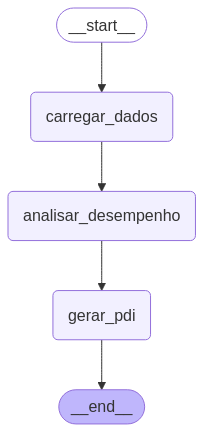

In [35]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

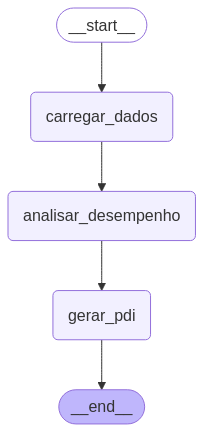

In [36]:
from IPython.display import Image, display

graph_image = app.get_graph().draw_mermaid_png()
display(Image(graph_image))  # Display in Jupyter Notebook

# Save the image manually
with open("agent_diagram.png", "wb") as f:
    f.write(graph_image)
